# Implement CREPE and train on MIR-1K vocals for pitch transcription

https://github.com/marl/crepe/blob/master/crepe/core.py

In [1]:
from matplotlib import pyplot as plt
import random 
import pandas as pd
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.nn.functional as nnF
import torchaudio
import torchaudio.functional as taF
from torch.utils.data import TensorDataset, DataLoader
import scipy
from scipy.io import wavfile
import seaborn as sns
sns.set()

import os
import sys
sys.path.append(os.path.abspath(os.path.join('../')))

from src.crepe_model import CREPEModel


# use GPU if available, otherwise, use cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

/Users/wenqinglim/workdir/qmul/singing_transcription/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read single wav file

In [2]:
wav_fname = 'MIR-1K/MIR-1K/Wavfile/abjones_1_01.wav'

In [5]:
samples, original_rate = torchaudio.load(wav_fname)

In [6]:
original_rate

16000

In [7]:
samples.shape

torch.Size([2, 185856])

In [8]:
samples[1]

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0024, 0.0034, 0.0034])

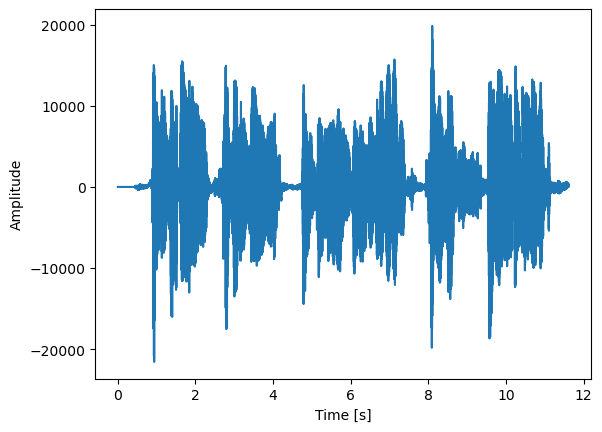

In [9]:
length = data.shape[0] / samplerate
time = np.linspace(0., length, data.shape[0])
plt.plot(time, data[:, 1], label="Right channel")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

In [10]:
# TO-DO: pre-process according to paper https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8683024
vocal = data[:, 1]

In [11]:
vocal

array([  0,   0,   0, ...,  78, 110, 110], dtype=int16)

## Read all data

In [2]:
files = os.listdir('MIR-1K/MIR-1K/Wavfile')
num_files = len(files)
num_classes = 410

In [3]:
# Save artist names for reproducibility

train_artists = ['khair',
 'heycat',
 'amy',
 'fdps',
 'Ani',
 'Kenshin',
 'bobon',
 'yifen',
 'davidson',
 'bug',
 'annar',
 'abjones',
 'geniusturtle',
 'stool',
 'tammy']

val_artists = ['titon', 'ariel']
test_artists = ['jmzen', 'leon']

In [4]:
def audio_to_frames(vocals):
    # make 1024-sample frames of the audio with hop length of 10 milliseconds
    num_samples = len(vocals)
    num_frames = int((num_samples - 1024) / 160) + 1
    frames = vocals.unfold(step=160, size=1024, dimension=0)
    return frames

def pitch_to_frame(annotations, num_frames, num_pitches=410):
    num_classes = num_pitches
    annotation_matrix = torch.zeros((num_frames, num_classes+1)) # Extra +1 class for NA notes
    print(annotation_matrix.shape)
    note_range = list(librosa.midi_to_note([i/10 for i in range(360 , 770)], cents=True))
    print(len(note_range))
    for idx in range(num_frames): # iterate each frame, assign pitch label to each frame
        pitch_idx = round(((512+(idx*160))/16000) / 0.02) - 1
        frame_pitch = annotations[pitch_idx]
        if frame_pitch in note_range:
            annotation_matrix[idx, note_range.index(frame_pitch)] = 1
        else:
            # If note it out of range (e.g. 0 values), assign to NA
            annotation_matrix[idx, len(note_range)] = 1
    return annotation_matrix

def load_pitch_labels(file_path):
    pitch_label = np.loadtxt(file_path, dtype=float)
    
    # Convert semitone to discrete note value
    pitch_midi = librosa.midi_to_note(np.round(pitch_label, 1), cents=True)
    pitch_midi[pitch_midi=='C-1+0'] = 'NA'
    return pitch_midi

In [5]:
note_range = list(librosa.midi_to_note([i/10 for i in range(360 , 770)], cents=True))

In [9]:
print(f"There are {len(note_range)} possible notes ranging from {note_range[0]} to {note_range[-1]}.")

There are 410 possible notes ranging from C2+0 to F5-10.


In [10]:
def get_split_by_artist(artist_name, train, val, test):
    if artist_name in train:
        return 'train'
    elif artist_name in val:
        return 'val'
    elif artist_name in test:
        return 'test'

In [11]:
'''
 - Load the data into train, val, test based on artist names
 - Extract audio into 1024-length frames with hop size 10ms
 - Annotation: one element corresponding to one audio file
'''

data = {'train': [],
       'val': [],
       'test': []}
labels = {'train': [],
       'val': [],
       'test': []}


for i, file_id in enumerate(files[:100]):
    print(f"reading {file_id}")
    file_artist = file_id.split('_')[0]
    split = get_split_by_artist(file_artist, train_artists, val_artists, test_artists)
    waveform, sample_rate = torchaudio.load(f"MIR-1K/MIR-1K/Wavfile/{file_id}")
    vocals = waveform[1]
    # print(vocals)

    # make 1024-sample frames of the audio with hop length of 10 milliseconds
    frames = audio_to_frames(vocals)
    # print(frames.shape)
    data[split].append(frames)
    num_frames=len(frames)
    # print(num_frames)

    pitch_midi_labels = load_pitch_labels(f"MIR-1K/MIR-1K/PitchLabel/{file_id.split('.')[0]}.pv")
    # print(pitch_midi_labels)
    annotation_matrix = pitch_to_frame(pitch_midi_labels, num_frames=num_frames, num_pitches=num_classes)
    # print(annotation_matrix.sum())
    labels[split].append(annotation_matrix)


reading leon_2_06.wav
torch.Size([646, 411])
410
reading leon_6_04.wav
torch.Size([861, 411])
410
reading geniusturtle_5_03.wav
torch.Size([1063, 411])
410
reading titon_1_06.wav
torch.Size([605, 411])
410
reading bug_5_10.wav
torch.Size([823, 411])
410
reading amy_11_05.wav
torch.Size([1137, 411])
410
reading leon_7_03.wav
torch.Size([778, 411])
410
reading amy_10_02.wav
torch.Size([1025, 411])
410
reading amy_6_09.wav
torch.Size([877, 411])
410
reading amy_8_06.wav
torch.Size([925, 411])
410
reading annar_4_01.wav
torch.Size([759, 411])
410
reading jmzen_1_03.wav
torch.Size([1140, 411])
410
reading bobon_4_04.wav
torch.Size([596, 411])
410
reading yifen_1_05.wav
torch.Size([497, 411])
410
reading khair_3_03.wav
torch.Size([653, 411])
410
reading amy_15_03.wav
torch.Size([689, 411])
410
reading ariel_3_03.wav
torch.Size([858, 411])
410
reading ariel_1_03.wav
torch.Size([1009, 411])
410
reading yifen_3_08.wav
torch.Size([948, 411])
410
reading khair_5_06.wav
torch.Size([788, 411])
410


In [12]:
train_data = torch.cat(data['train'])
valid_data = torch.cat(data['val'])
test_data = torch.cat(data['test'])

train_labels = torch.cat(labels['train'])
valid_labels = torch.cat(labels['val'])
test_labels = torch.cat(labels['test'])

print(train_data.shape, valid_data.shape, test_data.shape)
print(train_labels.shape, valid_labels.shape, test_labels.shape)

torch.Size([62830, 1024]) torch.Size([6816, 1024]) torch.Size([10088, 1024])
torch.Size([62830, 411]) torch.Size([6816, 411]) torch.Size([10088, 411])


## Define model

In [23]:
'''
Each convolutional layer is
preceded with batch normalization [21] and followed by a dropout
layer [22] with the dropout probability 0.25
'''

class PrintLayer(nn.Module):
    """
    Printing class for debugging
    """
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.shape)
        return x

class CREPEModel(nn.Module):
    """The CREPE model"""
    def __init__(self, mult=4):
        super(CREPEModel, self).__init__()
        self.mult=mult

        self.model = nn.Sequential(            
            # input dim = 1024*1*1
            nn.Conv2d(in_channels=1, out_channels=self.mult*32, kernel_size=(512, 1), stride=(4, 1), padding=(254,0), bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.mult*32),
            nn.MaxPool2d(kernel_size=(2,1), padding=0), 
            nn.Dropout(0.25),
            # PrintLayer(),
            
            nn.Conv2d(in_channels=self.mult*32, out_channels=self.mult*4, kernel_size=(64, 1), stride=(1, 1), padding='same', bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.mult*4),
            nn.MaxPool2d(kernel_size=(2,1), padding=0), 
            nn.Dropout(0.25),
            # PrintLayer(),
            
            nn.Conv2d(in_channels=self.mult*4, out_channels=self.mult*4, kernel_size=(64, 1), stride=(1, 1), padding='same', bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.mult*4),
            nn.MaxPool2d(kernel_size=(2,1), padding=0), 
            nn.Dropout(0.25),
            # PrintLayer(),

            nn.Conv2d(in_channels=self.mult*4, out_channels=self.mult*4, kernel_size=(64, 1), stride=(1, 1), padding='same', bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.mult*4),
            nn.MaxPool2d(kernel_size=(2,1), padding=0), 
            nn.Dropout(0.25),
            # PrintLayer(),

            nn.Conv2d(in_channels=self.mult*4, out_channels=self.mult*8, kernel_size=(64, 1), stride=(1, 1), padding='same', bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.mult*8),
            nn.MaxPool2d(kernel_size=(2,1), padding=0), 
            nn.Dropout(0.25),
            # PrintLayer(),

            nn.Conv2d(in_channels=self.mult*8, out_channels=self.mult*16, kernel_size=(64, 1), stride=(1, 1), padding='same', bias=False), 
            nn.ReLU(),
            nn.BatchNorm2d(num_features=self.mult*16),
            nn.MaxPool2d(kernel_size=(2,1), padding=0), 
            nn.Dropout(0.25),
            # PrintLayer(),
            
            nn.Flatten(),
            nn.Linear(in_features=4*1*self.mult*16, out_features=410+1, bias=True),
            nn.Sigmoid(),
        )

        self.apply(self._init_weights)


    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.kaiming_uniform_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.BatchNorm2d):
            torch.nn.init.ones_(module.weight)


    def forward(self, x):
        return self.model(x.unsqueeze(1))

In [ ]:
# Learn statistics from train set only!
train_mean = train_data.mean(axis=(0, 1), keepdims=True)
train_std = train_data.std(axis=(0, 1), keepdims=True)
print(train_mean, train_std)

# Apply train set statistics to all splits
train_data = torch.clip((train_data - train_mean) / train_std, min=1e-8, max=None)
valid_data = torch.clip((valid_data - train_mean) / train_std, min=1e-8, max=None)
test_data = torch.clip((test_data - train_mean) / train_std, min=1e-8, max=None)

print(train_data.shape, valid_data.shape, test_data.shape)

tensor([[0.3302]]) tensor([[0.6109]])


In [15]:
batch_size = 20

train_loader = DataLoader(TensorDataset(train_data, train_labels), batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(valid_data, valid_labels), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(test_data, test_labels), batch_size=batch_size, shuffle=False)

In [16]:
def evaluate(model, data_loader, threshold=0.7, error_range=5):
    model.eval()
    accuracy_all = 0.
    accuracy = 0.
    accuracy_10 = 0.
    accuracy_50 = 0.
    num_gt_pitches = 0
    with torch.no_grad():
        for batch_inputs, batch_labels in data_loader:
            try:
                batch_inputs = torch.reshape(batch_inputs, (batch_inputs.shape[0],1024,1)).to(device)
            except:
                print(batch_inputs.shape)
            batch_labels = batch_labels.to(device)
            batch_outputs = model(batch_inputs).squeeze(dim=1)
            
            # get output prediction indices
            batch_output_arg = torch.argmax(batch_outputs, dim=1)
            
            # Count number of correct predictions (including non-pitch prediction)
            # get labels at predicted indices
            label_values = batch_labels[range(len(batch_output_arg)), batch_output_arg]
            accuracy_all += torch.count_nonzero(label_values)

            # Count number of correct pitch predictions
            pitch_labels = torch.clone(batch_labels)
            pitch_labels[:, -1] = 0
            num_gt_pitches += pitch_labels.sum()
            label_values = pitch_labels[range(len(batch_output_arg)), batch_output_arg]
            accuracy += torch.count_nonzero(label_values)

            # Add error range to labels
            batch_labels_range = torch.clone(pitch_labels)
            
            for i in range(1, error_range+1):
                # Shift label to +- i indices (each index is a 10 cent error range)
                batch_labels_range += pitch_labels.roll(shifts=i, dims=1) 
                batch_labels_range += pitch_labels.roll(shifts=-i, dims=1)
                if i == 1:
                    # Count number of correct pitch predictions with 10-cent error range
                    label_values = batch_labels_range[range(len(batch_output_arg)), batch_output_arg]
                    accuracy_10 += torch.count_nonzero(label_values)

                elif i == 5:
                    # Count number of correct pitch predictions with 50-cent error range
                    label_values = batch_labels_range[range(len(batch_output_arg)), batch_output_arg]
                    accuracy_50 += torch.count_nonzero(label_values)
                
            
    accuracy_all /= len(data_loader.dataset)
    accuracy /= num_gt_pitches
    accuracy_10 /= num_gt_pitches
    accuracy_50 /= num_gt_pitches
    return accuracy_all.item(), accuracy.item(), accuracy_10.item(), accuracy_50.item()

In [17]:
def train(model, train_loader, valid_loader, criterion, optimizer, num_epochs, saved_model, evaluate_every_n_epochs=1):
    model.train()
    num_batches = len(train_loader)
    best_valid_acc = 0.0 # for keeping track of the best accuracy on the validation data
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_inputs, batch_labels in train_loader:
            try:
                batch_inputs = torch.reshape(batch_inputs, (batch_inputs.shape[0],1024,1)).to(device)
            except:
                print(batch_inputs.shape)
            batch_labels = batch_labels.to(device)

            # forward + backward + optimize
            outputs = model(batch_inputs).squeeze(dim=1)
            loss = criterion(outputs, batch_labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # accumulate loss
            epoch_loss += loss.item()

        epoch_loss /= num_batches
        # print training loss
        metrics['loss'].append(epoch_loss)
        print(f'[{epoch+1}] loss: {epoch_loss:.6f}')
        
        # evaluate the network on the validation data
        if((epoch+1) % evaluate_every_n_epochs == 0):
            valid_acc_all, valid_acc, valid_acc_10, valid_acc_50 = evaluate(model, valid_loader)
            metrics['val_accuracy_all'].append(100*valid_acc_all)
            metrics['val_accuracy'].append(100*valid_acc)
            metrics['val_accuracy_10'].append(100*valid_acc_10)
            metrics['val_accuracy_50'].append(100*valid_acc_50)
            print(f'Validation accuracy (all): {100*valid_acc_all:.2f}%; accuracy (pitch only): {100*valid_acc:.2f}%; accuracy (+-10c): {100*valid_acc_10:.2f}%; accuracy (+-50c): {100*valid_acc_50:.2f}%')
            
            # if the best validation performance so far, save the network to file 
            if(valid_acc >= best_valid_acc):
                best_valid_acc = valid_acc
                print('Saving best model')
                torch.save(model.state_dict(), saved_model)

In [24]:
num_epochs = 10 # the number of training epoch (when you've gone through all samples of the training data, that's one epoch)
# saved_model = './best_model.pkl' # path for saving the best model during training
evaluate_every_n_epochs = 1 # how often you want to evaluate the network during training?
# metrics_all = {}
model_size_mult = [4, 8, 16, 24, 32]
for mult in model_size_mult:
    saved_model = f"./best_crepe_{mult}.pkl" # path for saving the best model during training
    metrics = {"loss":[],
               "val_accuracy_all": [],
               "val_accuracy": [],
               "val_accuracy_10": [],
               "val_accuracy_50": [],
          
          }
    model = CREPEModel(mult).to(device)
    print(f"Initialized model with multiplier {model.mult}")
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
    train(model, train_loader, valid_loader, criterion, optimizer, num_epochs, saved_model, evaluate_every_n_epochs)
    metrics_all[str(mult)] = metrics
    del model
    torch.cuda.empty_cache()

Initialized model with multiplier 8
[1] loss: 0.017549
Validation accuracy (all): 69.57%; accuracy (pitch only): 59.58%; accuracy (+-10c): 59.58%; accuracy (+-50c): 90.24%
Saving best model
[2] loss: 0.003820
Validation accuracy (all): 75.34%; accuracy (pitch only): 68.06%; accuracy (+-10c): 68.06%; accuracy (+-50c): 94.13%
Saving best model
[3] loss: 0.003347
Validation accuracy (all): 79.30%; accuracy (pitch only): 73.68%; accuracy (+-10c): 73.68%; accuracy (+-50c): 95.25%
Saving best model
[4] loss: 0.003077
Validation accuracy (all): 79.14%; accuracy (pitch only): 73.76%; accuracy (+-10c): 73.76%; accuracy (+-50c): 95.83%
Saving best model
[5] loss: 0.002859
Validation accuracy (all): 78.40%; accuracy (pitch only): 72.83%; accuracy (+-10c): 72.83%; accuracy (+-50c): 95.23%
[6] loss: 0.002663
Validation accuracy (all): 79.62%; accuracy (pitch only): 74.16%; accuracy (+-10c): 74.16%; accuracy (+-50c): 94.95%
Saving best model
[7] loss: 0.002491
Validation accuracy (all): 79.31%; accu

In [35]:
dfs = []
for mult, metrics in metrics_all.items():
    dfs.append(pd.DataFrame(metrics))

In [36]:
dfs[0]

,loss,val_accuracy_all,val_accuracy,val_accuracy_10,val_accuracy_50
0,0.029185,30.237678,5.925778,5.925778,17.777334
1,0.005574,72.491199,64.006382,64.006382,91.400641
2,0.003690,76.159036,69.213885,69.213885,94.732642
3,0.003321,77.934271,71.608138,71.608138,95.111734
4,0.003110,79.254699,73.343974,73.343974,95.091778
5,0.002950,78.902584,72.984838,72.984838,95.051873
6,0.002818,78.785211,73.324025,73.324025,95.530725
7,0.002709,79.548120,74.441344,74.441344,95.011973
8,0.002621,78.946596,73.224264,73.224264,95.071828
9,0.002509,79.196012,74.022347,74.022347,95.291299


In [19]:
metrics

{'loss': [0.029184676336277488,
  0.005574308258306738,
  0.003689968342444356,
  0.0033207987932576356,
  0.003109581984874047,
  0.002949834807509071,
  0.0028176977453509703,
  0.0027091351570524475,
  0.0026206413886880647,
  0.0025090306767136246],
 'val_accuracy_all': [30.237677693367004,
  72.49119877815247,
  76.15903615951538,
  77.93427109718323,
  79.25469875335693,
  78.90258431434631,
  78.78521084785461,
  79.54812049865723,
  78.94659638404846,
  79.19601202011108],
 'val_accuracy': [5.925778299570084,
  64.00638222694397,
  69.21388506889343,
  71.60813808441162,
  73.34397435188293,
  72.98483848571777,
  73.32402467727661,
  74.4413435459137,
  73.22426438331604,
  74.02234673500061],
 'val_accuracy_10': [5.925778299570084,
  64.00638222694397,
  69.21388506889343,
  71.60813808441162,
  73.34397435188293,
  72.98483848571777,
  73.32402467727661,
  74.4413435459137,
  73.22426438331604,
  74.02234673500061],
 'val_accuracy_50': [17.77733415365219,
  91.40064120292664

### Plot Metrics

In [63]:
model_size_mult = [4, 8, 16, 24, 32]

def plot_lineplots(metric, dfs):
    for idx, mult in enumerate(model_size_mult):
        sns.lineplot(dfs[idx][metric], label=f'Num filters X{mult}')
        plt.xlabel("Epochs")
        plt.title(f"{metric} across epochs")

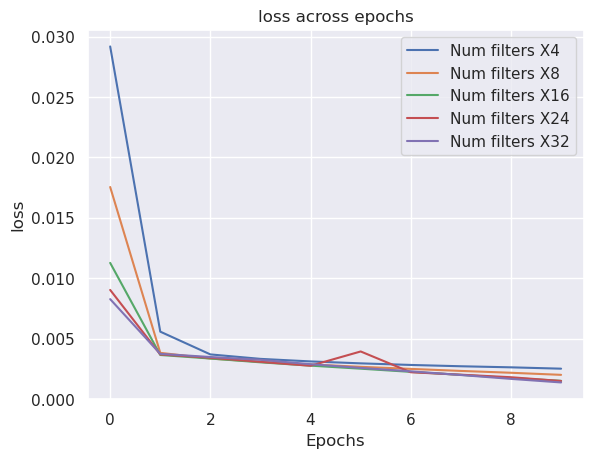

In [64]:
plot_lineplots("loss", dfs)

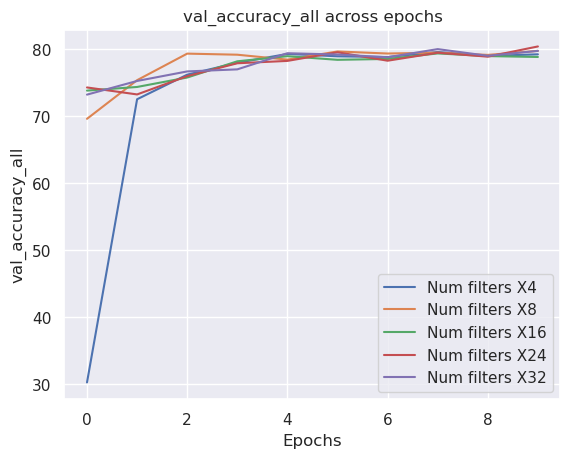

In [65]:
plot_lineplots("val_accuracy_all", dfs)

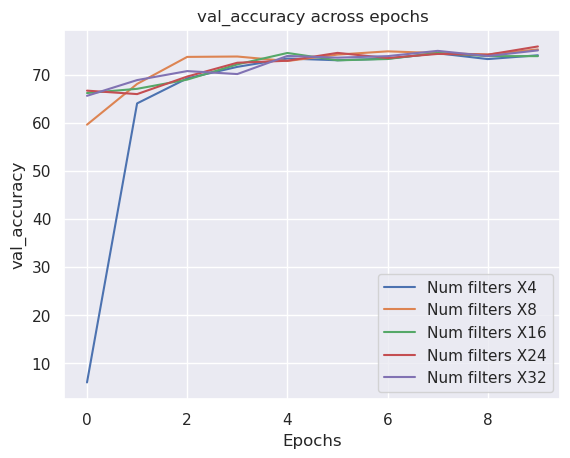

In [66]:
plot_lineplots("val_accuracy", dfs)

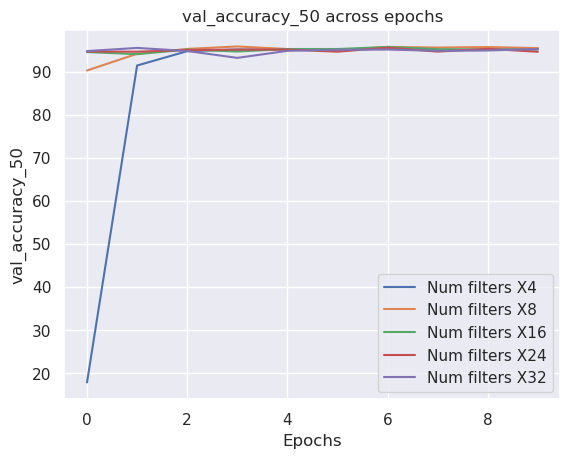

In [67]:
plot_lineplots("val_accuracy_50", dfs)

In [78]:
# evaluate on the test data
test_metrics = {}
for idx, mult in enumerate(model_size_mult):
    metrics = {
               "accuracy_all": [],
               "accuracy": [],
               "accuracy_10": [],
               "accuracy_50": [],
          
          }
    model = CREPEModel(mult).to(device)
    model.load_state_dict(torch.load(f'best_crepe_{mult}.pkl'))
    model.eval()
    
    test_acc_all, test_acc, test_acc_10, test_acc_50 = evaluate(model, test_loader)
    print(f'Num Filters X{mult} - Test accuracy_all: {100*test_acc_all:.2f}%; pitch accuracy: {100*test_acc:.2f}%; pitch accuracy (+-10c): {100*test_acc_10:.2f}%; pitch accuracy (+-50c): {100*test_acc_50:.2f}%')
    metrics['accuracy_all']= 100*test_acc_all
    metrics['accuracy'] = 100*test_acc
    metrics['accuracy_10'] = 100*test_acc_10
    metrics['accuracy_50'] = 100*test_acc_50
    test_metrics[str(mult)] = metrics
    
    del model
    torch.cuda.empty_cache()

Num Filters X4 - Test accuracy_all: 63.52%; pitch accuracy: 50.53%; pitch accuracy (+-10c): 56.41%; pitch accuracy (+-50c): 85.85%
Num Filters X8 - Test accuracy_all: 65.53%; pitch accuracy: 53.53%; pitch accuracy (+-10c): 58.88%; pitch accuracy (+-50c): 88.23%
Num Filters X16 - Test accuracy_all: 66.16%; pitch accuracy: 54.44%; pitch accuracy (+-10c): 60.25%; pitch accuracy (+-50c): 88.65%
Num Filters X24 - Test accuracy_all: 65.44%; pitch accuracy: 53.49%; pitch accuracy (+-10c): 59.21%; pitch accuracy (+-50c): 88.40%
Num Filters X32 - Test accuracy_all: 66.28%; pitch accuracy: 54.38%; pitch accuracy (+-10c): 60.15%; pitch accuracy (+-50c): 88.83%


In [86]:
test_metrics_df = pd.DataFrame.from_dict(test_metrics, orient='index').reset_index(names="num_filters_x")

In [87]:
test_metrics_df

,num_filters_x,accuracy_all,accuracy,accuracy_10,accuracy_50
0,4,63.521016,50.526172,56.410968,85.848796
1,8,65.533304,53.530878,58.875656,88.230407
2,16,66.157812,54.444754,60.246468,88.645804
3,24,65.444094,53.489339,59.207976,88.396567
4,32,66.276765,54.375517,60.149544,88.825810


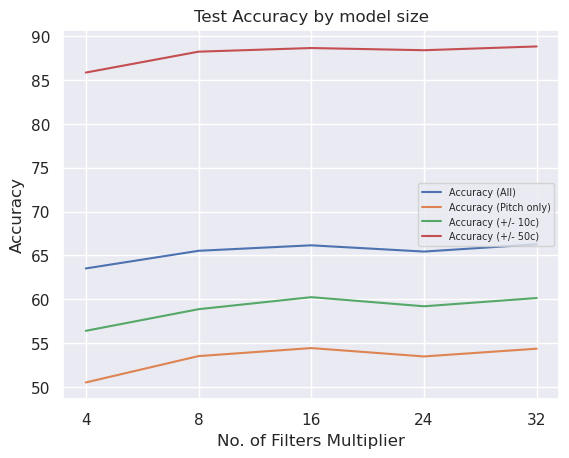

In [110]:
sns.lineplot(data=test_metrics_df, x='num_filters_x', y='accuracy_all', label="Accuracy (All)")
sns.lineplot(data=test_metrics_df, x='num_filters_x', y='accuracy', label="Accuracy (Pitch only)")
sns.lineplot(data=test_metrics_df, x='num_filters_x', y='accuracy_10', label="Accuracy (+/- 10c)")
sns.lineplot(data=test_metrics_df, x='num_filters_x', y='accuracy_50', label="Accuracy (+/- 50c)")

plt.title(f"Test Accuracy by model size")
plt.ylabel("Accuracy")
plt.xlabel("No. of Filters Multiplier")

plt.legend(loc='center right', fontsize='xx-small')

In [7]:
# Read best model and save to hugginface
mult = 24
best_model = CREPEModel(mult).to(device)
best_model.load_state_dict(torch.load(f'../models/best_crepe_{mult}.pkl', map_location=torch.device("cpu")))
best_model.push_to_hub(f"omgitsqing/CREPE_MIR-1K_{mult}")

/var/folders/9y/fkx5lf9n2d7ghhdt5tg5y0jm0000gn/T/ipykernel_53845/1925982104.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(f'../mo

CommitInfo(commit_url='https://huggingface.co/omgitsqing/CREPE_MIR-1K_24/commit/ba92243bb5bb152d0e20ceed88a0d775bf9925f2', commit_message='Push model using huggingface_hub.', commit_description='', oid='ba92243bb5bb152d0e20ceed88a0d775bf9925f2', pr_url=None, repo_url=RepoUrl('https://huggingface.co/omgitsqing/CREPE_MIR-1K_24', endpoint='https://huggingface.co', repo_type='model', repo_id='omgitsqing/CREPE_MIR-1K_24'), pr_revision=None, pr_num=None)